1) An expert can understand a set of one features as a concept, whereas for a black-box model a concept in unsupervised setting will be a set of absolutely different features (correlated ones and so on)
   

In [2]:
import scipy
import joblib
import sklearn
import numpy as np
import pandas as pd
import os.path as osp
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler 
import tensorflow as tf

from tabcbm.models.architectures import construct_encoder, construct_decoder
from tabcbm.models.architectures import construct_end_to_end_model
from tabcbm.models.tabcbm import TabCBM

# Read the data 

In [3]:
# Reading already preprocessed train and test data 

data_dir = 'D:\\PycharmProjects\\AMMISproject\\data\\processed_data'
dataset = 'dataco'

x_train_std = joblib.load(osp.join(data_dir, dataset, 'x_train_std.joblib'))
x_test_std = joblib.load(osp.join(data_dir, dataset, 'x_test_std.joblib'))

x_train = joblib.load(osp.join(data_dir, dataset, 'x_train.joblib'))
x_test = joblib.load(osp.join(data_dir, dataset, 'x_test.joblib'))

y_train = joblib.load(osp.join(data_dir, dataset, 'y_train.joblib'))
y_test = joblib.load(osp.join(data_dir, dataset, 'y_test.joblib'))

print('Shape of the training set: ', x_train_std.shape)
print('Shape of the test set: ', x_test_std.shape)
print('Shape of the trainigb targets: ', y_train.shape)


Shape of the training set:  (120935, 40)
Shape of the test set:  (51830, 40)
Shape of the trainigb targets:  (120935,)


In [4]:
rus = RandomUnderSampler(sampling_strategy='all', random_state=0)

x_train_reduced, y_train_reduced = rus.fit_resample(x_train_std, y_train) 
x_train_reduced.shape

(103416, 40)

In [5]:
# Defining the concepts 

aggregated_concepts = {
    'Shipment': ['Type', 'Days for shipment (scheduled)', 'Shipping Mode', 'Distance (km)'],
    'Customer': ['Customer Zipcode', 'Customer Segment'],
    'Department': ['Department Name', 'Market'],
    'Store': ['Store Latitude', 'Store Longitude'],
    'Order': ['Order Id', 'order date (DateOrders)', 'Order Longitude', 'Order Latitude',
              'Benefit per order', 'Order Item Total', 'Order Status', 'Sales', 
              'Order Item Discount', 'order_year', 'order_month', 'order_day'],
    'Product': ['Category Name']
}

# In the preprocessed data the naming of the columns differs, so we have to define
# expanded features and put them as a value of a corresponding concept
extended_concepts = {}
for concept, features in aggregated_concepts.items():
    extended_features = []
    for value in features:
            [extended_features.append(column) for column in x_train_std.columns if value in column]
   
    extended_concepts[concept] = extended_features


In [6]:
# Creating masks for each concept 

concepts_num = len(aggregated_concepts)
all_features = x_train_std.columns

total_features_num = len(all_features) 

concepts_masks = pd.DataFrame(0, columns=all_features, index=list(aggregated_concepts.keys()))

for concept, features in extended_concepts.items():
    for feature in features:
        concepts_masks.loc[concept, feature] = 1

## Create main components for TabCBM

In [7]:
x_train = x_train_reduced
y_train = y_train_reduced

x_test = x_test_std

In [8]:
# Parameters defining the architecture we will use

input_shape = x_train_std.shape[1:]
num_outputs = len(set(y_train))
encoder_units = [16, 16]
decoder_units = [16]
latent_dims = 16
learning_rate = 0.001
validation_size = 0.1

print('Input shape: ', input_shape)
print('Number of outputs: ', num_outputs)

Input shape:  (40,)
Number of outputs:  2


In [ ]:
tabcbm_params = dict(
    input_shape = x_train_std.shape[1:]
    num_outputs = len(set(y_train))
    encoder_units = [16, 16]
    decoder_units = [16]
    latent_dims = 16
    learning_rate = 0.001
    validation_size = 0.1
)

In [ ]:
def create_end_to_end_tabsbm(**kwargs):
    input_shape = kwargs['input_shape']

    encoder = construct_encoder(input_shape, **kwargs)

    decoder_inputs = tf.keras.Input(shape=[latent_dims])
    decoder_graph = construct_decoder(**kwargs)
    decoder = tf.keras.Model(
        decoder_inputs,
        decoder_graph(decoder_inputs),
        name="decoder",
    )
    
    end_to_end_model, encoder, decoder = construct_end_to_end_model(input_shape,
                                                                encoder,
                                                                decoder,
                                                                num_outputs,
                                                                learning_rate)

In [9]:
# Next, we build the feature to latent code encoder model (i.e., phi)
encoder = construct_encoder(input_shape, encoder_units, latent_dims)

In [192]:
# Then, we build the concept to label model  (i.e., the label predictor f)

decoder_inputs = tf.keras.Input(shape=[latent_dims])
decoder_graph = construct_decoder(decoder_units, num_outputs)
decoder = tf.keras.Model(
    decoder_inputs,
    decoder_graph(decoder_inputs),
    name="decoder",
)

In [193]:
# We then put them both together to make an end-to-end model we can pretrain

end_to_end_model, encoder, decoder = construct_end_to_end_model(input_shape,
                                                                encoder,
                                                                decoder,
                                                                num_outputs,
                                                                learning_rate)

end_to_end_model.summary()

pretrain_epochs = 30
batch_size = 512
pretrain_hist = end_to_end_model.fit(
    x=x_train,
    y=y_train,
    epochs=pretrain_epochs,
    batch_size=batch_size,
    validation_split=validation_size,
    verbose=1,
)

Model: "complete_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,457 (5.69 KB)

 Trainable params: 1,457 (5.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.5918 - loss: 0.6500 - val_binary_accuracy: 0.5024 - val_loss: 0.6650
Epoch 2/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - binary_accuracy: 0.7366 - loss: 0.5406 - val_binary_accuracy: 0.4760 - val_loss: 0.7055
Epoch 3/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7357 - loss: 0.5331 - val_binary_accuracy: 0.5165 - val_loss: 0.6475
Epoch 4/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - binary_accuracy: 0.7362 - loss: 0.5335 - val_binary_accuracy: 0.5002 - val_loss: 0.6736
Epoch 5/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7376 - loss: 0.5307 - val_binary_accuracy: 0.5123 - val_loss: 0.6643
Epoch 6/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - binary_accuracy: 0.7372 - loss: 0.5303 - val_binary_accuracy: 0.4914 - val_loss: 0.7058
Epoch 7/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - binary_accuracy: 0.7387 - loss: 0.5292 - val_binary_accuracy: 0.5251 - val_loss: 0.638

In [195]:
# Evaluate pretrained model

# We will accumulate all metrics/results in the same dictionary
results = {}

end_to_end_preds = end_to_end_model.predict(
    x_test,
    batch_size=batch_size,
)

# We assume that we have outputed logits
if np.min(end_to_end_preds) < 0.0 or np.max(end_to_end_preds) > 1:
    end_to_end_preds = tf.math.sigmoid(end_to_end_preds).numpy()
end_to_end_preds = (end_to_end_preds >= 0.5).astype(np.int32)
results['pre_train_acc'] = sklearn.metrics.accuracy_score(
    y_test,
    end_to_end_preds,
)
results['pre_train_auc'] = sklearn.metrics.roc_auc_score(
    y_test,
    end_to_end_preds,
)
print(f"Pretrained model task accuracy: {results['pre_train_acc']*100:.2f}%")


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
Pretrained model task accuracy: 69.96%


# Construct TabCBM

For this, we will first compute the empirical covariance matrix in order for us to learn useful masks using a similar approach to that proposed by SEFS:

In [196]:
# Construct the training set's empirical covariance matrix
# NOTE: This step can be very computationally expensive/intractable in large
#       datasets. In those cases, one may ignore the covariance matrix when
#       performing TabCBM's pretraining at the potential cost of performance or
#       more accurate concept discovery.
cov_mat = np.corrcoef(x_train.T)
print(cov_mat)

[[ 1.00000000e+00 -1.36071957e-03  7.91785450e-03 ... -3.70337549e-03
   3.40013685e-03 -6.15914871e-04]
 [-1.36071957e-03  1.00000000e+00  3.39125553e-03 ...  3.68143779e-03
  -1.50537796e-03 -7.14249036e-03]
 [ 7.91785450e-03  3.39125553e-03  1.00000000e+00 ...  6.07207893e-03
   2.14358816e-03  1.68781787e-03]
 ...
 [-3.70337549e-03  3.68143779e-03  6.07207893e-03 ...  1.00000000e+00
  -1.98689043e-01 -1.37803989e-01]
 [ 3.40013685e-03 -1.50537796e-03  2.14358816e-03 ... -1.98689043e-01
   1.00000000e+00 -2.08158793e-01]
 [-6.15914871e-04 -7.14249036e-03  1.68781787e-03 ... -1.37803989e-01
  -2.08158793e-01  1.00000000e+00]]


In [197]:
# Number of concepts we want to discover
n_concepts = 6

# Set the weights for the different regularisers in the loss
coherence_reg_weight = 0.1  # $lambda_{co}
diversity_reg_weight = 5  # $lambda_{div}
feature_selection_reg_weight = 5  # $lambda_{spec}
gate_estimator_weight = 10  # Gate prediction regularizer for SEFS's pre-text task

# Select how many neighbors to use for the coherency loss (must be less than the batch size!)
top_k = 256

In [198]:
# Generate a dictionary with the parameters to use for TabCBM as we will have
# to use the same parameters twice:
tab_cbm_params = dict(
    features_to_concepts_model=encoder,  # The $\phi$ sub-model
    concepts_to_labels_model=decoder,  # The $f$ sub-model
    latent_dims=latent_dims,  # The dimensionality of the concept embeddings $m$
    n_concepts=n_concepts,  # The number of concepts to discover $k^\prime$
    cov_mat=cov_mat,  # The empirical covariance matrix
    loss_fn=end_to_end_model.loss,  # The downstream task loss function
    # Then we provide all the regularizers weights
    coherence_reg_weight=coherence_reg_weight,
    diversity_reg_weight=diversity_reg_weight,
    feature_selection_reg_weight=feature_selection_reg_weight,
    gate_estimator_weight=gate_estimator_weight,
    top_k=top_k,

    # And indicate that we will not be providing any supervised concepts! Change
    # this is training concepts (e.g., `c_train`) are provided/known during
    # training
    n_supervised_concepts=0,
    concept_prediction_weight=0,

    # The accuracy metric to use for logging performance
    acc_metric=(
        lambda y_true, y_pred: tf.math.reduce_mean(
            tf.keras.metrics.sparse_categorical_accuracy(
                y_true,
                y_pred,
            )
        )
    ),

    # ANd architectural details of the self-supervised reconstruction modules
    concept_generator_units=[64],
    rec_model_units=[64],
)

In [199]:
# Mask Generator Self-supervised Training

# Next, we proceed to do the SELF-SUPERVISED TRAINING of the MASK
# GENERATORS for TabCBM. For this, we will follow a similar approach
# to that of SEFS. Our TabCBM module allows one to do this by setting
# the self_supervised_mode flag to True before calling the .fit() method:

# We can now construct our TabCBM model which we will first self-supervise!
ss_tabcbm = TabCBM(self_supervised_mode=True,  **tab_cbm_params)
ss_tabcbm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate,))
ss_tabcbm.summary()


[WARNING] Assuming independence between features in TabCBM training.


d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "tab_cbm_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder (Functional)            │ (None, 1)              │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 16)             │        11,516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_0            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rec_values_model_0 (Sequential) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rec_mask_model (Sequential)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_1            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_2            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_3            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_4            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_5            │ ?                      │   0 (unbuilt) │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,429 (52.46 KB)

 Trainable params: 13,201 (51.57 KB)

 Non-trainable params: 228 (912.00 B)

In [202]:
self_supervised_train_epochs = 50
print("TabCBM self-supervised training stage...")
ss_tabcbm_hist = ss_tabcbm.fit(
    x=x_train,
    y=y_train,
    validation_split=validation_size,
    epochs=self_supervised_train_epochs,
    batch_size=batch_size,
    verbose=1,
)

print("\tTabCBM self-supervised training completed")

TabCBM self-supervised training stage...
Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 0.5985 - avg_mask_rec_loss: 5.4125 - loss: 36.0662 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 0.5984 - val_avg_mask_rec_loss: 5.2966 - val_loss: 35.3697
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - avg_concept_size: 0.0000e+00 - avg_features_rec_loss: 0.5983 - avg_mask_rec_loss: 5.3972 - loss: 35.9729 - max_probability: 0.0000e+00 - mean_probability: 0.0000e+00 - min_probability: 0.0000e+00 - prob_sparsity_loss: 0.0000e+00 - reg_loss_closest: 0.0000e+00 - reg_loss_similarity: 0.0000e+00 - task_loss: 0.0000e+00 - val_avg_features_rec_loss: 0.5981 - val_avg_mask_rec_loss: 5.2727 - val_loss: 3

In [203]:
# First we will instantiate a new TabCBM that is NOT in self-supervised mode,
# and we will load its weights so that they are the same as the model whose
# mask generators have been pre-trained using the SS loss.
tabcbm_supervised = TabCBM(
    self_supervised_mode=False,
    # Notice how we provide as concept generators the concept generators of the
    # SS TabCBM:
    concept_generators=ss_tabcbm.concept_generators,
    # as well as the feature probability masks:
    prior_masks=ss_tabcbm.feature_probabilities,
    **tab_cbm_params,
)
tabcbm_supervised.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
tabcbm_supervised.summary()

[WARNING] Assuming independence between features in TabCBM training.


d:\PycharmProjects\AMMISproject\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "tab_cbm_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder (Functional)            │ (None, 1)              │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 16)             │        11,516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_0            │ (None, 16)             │         3,536 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_1            │ (None, 16)             │         3,536 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_2            │ (None, 16)             │         3,536 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_3            │ (None, 16)             │         3,536 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_4            │ (None, 16)             │         3,536 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concept_generators_5            │ (None, 16)             │         3,536 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,645 (135.33 KB)

 Trainable params: 34,417 (134.44 KB)

 Non-trainable params: 228 (912.00 B)

In [204]:
max_epochs = 150   
print("TabCBM self-supervised training stage...")

tabcbm_hist = tabcbm_supervised.fit(
    x=x_train,
    y=y_train,
    validation_split=validation_size,
    epochs=max_epochs,
    batch_size=batch_size,
    verbose=1,
)

print("\tTabCBM supervised training completed")

TabCBM self-supervised training stage...
Epoch 1/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5552 - avg_concept_size: 17.8135 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 3.4177 - max_probability: 0.7191 - mean_probability: 0.4824 - min_probability: 0.2608 - prob_sparsity_loss: 2.4122 - reg_loss_closest: 0.0067 - reg_loss_similarity: 0.4374 - task_loss: 0.5747 - val_accuracy: 0.0000e+00 - val_loss: 3.2120 - val_prob_sparsity_loss: 2.2557 - val_reg_loss_closest: 0.0053 - val_reg_loss_similarity: 0.2762 - val_task_loss: 0.6854
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5559 - avg_concept_size: 13.4423 - avg_features_rec_loss: 0.0000e+00 - avg_mask_rec_loss: 0.0000e+00 - loss: 2.9965 - max_probability: 0.6792 - mean_probability: 0.4408 - min_probability: 0.2282 - prob_sparsity_loss: 2.2039 - reg_loss_closest: 0.0118 - reg_loss_similarity: 0.2703 - task_loss: 0.5340 - val_accuracy: 0.0000e+00 - val_loss: 2.9962 - val_p

# Evaluate TabCBM

In [205]:
test_y_pred, test_concept_scores = tabcbm_supervised.predict(x_test, batch_size=batch_size)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [206]:
if np.min(test_y_pred) < 0.0 or np.max(test_y_pred) > 1:
        # Then we assume that we have outputed logits
        test_preds = tf.math.sigmoid(test_y_pred).numpy()
        
test_preds = (test_preds > 0.5).astype(np.int32)
results['acc'] = sklearn.metrics.accuracy_score(
    y_test,
    test_preds,
)
results['auc'] = sklearn.metrics.roc_auc_score(
    y_test,
    test_preds,
)

print(f"Accuracy is {results['acc']*100:.2f}%")

Accuracy is 69.97%


In [222]:
test_concept_scores_df = pd.DataFrame(test_concept_scores, columns=list(aggregated_concepts.keys()))

Shape of the concept scores:  (51830, 6)


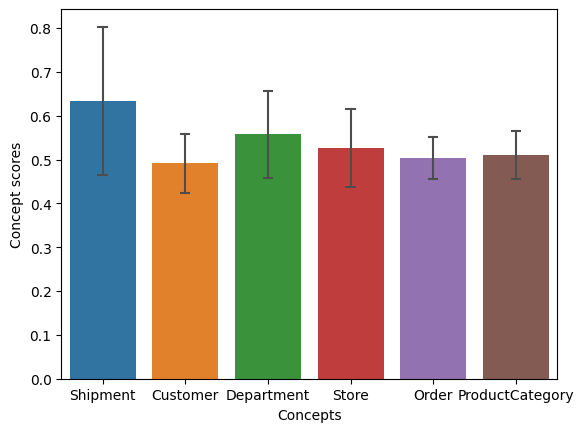

In [363]:
# Visualize concept scores

print('Shape of the concept scores: ', test_concept_scores.shape)

concept_scores_avg = test_concept_scores.mean(axis=0)
concept_scores_var = test_concept_scores.std(axis=0)

ax = sns.barplot(test_concept_scores_df, estimator='mean', errorbar='sd',
                 err_kws={"color": ".3", "linewidth": 1.5}, capsize=.1, legend=False)

ax.set(xlabel='Concepts', ylabel='Concept scores')
plt.savefig(f'tabcbm_test_concept_scores_k{n_concepts}', dpi=300)
plt.show()



## Comparison of the calculated and ground-truth masks 

In [241]:
# The masks are stored as logits, so we need to turn them to probabilities using
# a sigmoid
masks = tf.sigmoid(tabcbm_supervised.feature_probabilities).numpy()

print('Features that correspond to the defined concepts:\n')
for concept, features in extended_concepts.items():
    print('\t', f'{concept}: {features}' )

print("\nThresholded concept masks learnt by TabCBM:")
for i, mask in enumerate((masks>0.0005).astype(np.int32)):
    print("\tFor concept", i, "we are selecting the following features", mask)
    print("\tThe folllowing features are masked by the model: \n\t", [feature for feature, flag in zip(x_train_std.columns, mask) if flag == 1], "\n" )
   
print("-" * 80)
print("-" * 80)
print("For comparison, the ground truth concept masks are")
for i, mask in enumerate(concepts_masks.to_numpy()):
    print("\tFor GROUND-TRUTH concept", i, " the following features are relevant\n\t", mask)



Features that correspond to the defined concepts:

	 Shipment: ['Type_CASH', 'Type_DEBIT', 'Type_PAYMENT', 'Type_TRANSFER', 'Days for shipment (scheduled)', 'Shipping Mode_First Class', 'Shipping Mode_Same Day', 'Shipping Mode_Second Class', 'Shipping Mode_Standard Class']
	 Customer: ['Customer Zipcode', 'Customer Segment_Consumer', 'Customer Segment_Corporate', 'Customer Segment_Home Office']
	 Department: ['Department Name', 'Market_Africa', 'Market_Europe', 'Market_LATAM', 'Market_Pacific Asia', 'Market_USCA']
	 Store: ['Store Latitude', 'Store Longitude']
	 Order: ['Order Id', 'Order Profit Per Order', 'Order Status_CLOSED', 'Order Status_COMPLETE', 'Order Status_ON_HOLD', 'Order Status_PAYMENT_REVIEW', 'Order Status_PENDING', 'Order Status_PENDING_PAYMENT', 'Order Status_PROCESSING', 'Sales', 'Order Item Discount', 'order_year', 'order_month', 'order_day']
	 ProductCategory: ['Category Name']

Thresholded concept masks learnt by TabCBM:
	For concept 0 we are selecting the followi

In [242]:
# The masks are stored as logits, so we need to turn them to probabilities using
# a sigmoid
masks = tf.sigmoid(tabcbm_supervised.feature_probabilities).numpy()

print('Features that correspond to the defined concepts:\n')
for concept, features in extended_concepts.items():
    print(f'{concept}: {features}' )

print("\nThresholded concept masks learnt by TabCBM:")
for i, mask in enumerate((masks>0.0005).astype(np.int32)):
    print("\tFor concept", i, "we are selecting the following features", mask)

    print("\t", [feature for feature, flag in zip(x_train_std.columns, mask) if flag == 1], "\n" )

print("-" * 80)
print("-" * 80)

print("For comparison, the ground truth concept masks are")
for i in range(n_concepts):
    print("\tFor GROUND-TRUTH concept", i, " the following features are relevant", concepts_masks.iloc[i, :].values)


Features that correspond to the defined concepts:

Shipment: ['Type_CASH', 'Type_DEBIT', 'Type_PAYMENT', 'Type_TRANSFER', 'Days for shipment (scheduled)', 'Shipping Mode_First Class', 'Shipping Mode_Same Day', 'Shipping Mode_Second Class', 'Shipping Mode_Standard Class']
Customer: ['Customer Zipcode', 'Customer Segment_Consumer', 'Customer Segment_Corporate', 'Customer Segment_Home Office']
Department: ['Department Name', 'Market_Africa', 'Market_Europe', 'Market_LATAM', 'Market_Pacific Asia', 'Market_USCA']
Store: ['Store Latitude', 'Store Longitude']
Order: ['Order Id', 'Order Profit Per Order', 'Order Status_CLOSED', 'Order Status_COMPLETE', 'Order Status_ON_HOLD', 'Order Status_PAYMENT_REVIEW', 'Order Status_PENDING', 'Order Status_PENDING_PAYMENT', 'Order Status_PROCESSING', 'Sales', 'Order Item Discount', 'order_year', 'order_month', 'order_day']
ProductCategory: ['Category Name']

Thresholded concept masks learnt by TabCBM:
	For concept 0 we are selecting the following features 

In [246]:
trsh_masks = pd.DataFrame((masks>0.0005).astype(np.int32), columns=x_test.columns)

,Days for shipment (scheduled),Category Name,Customer Zipcode,Department Name,Store Latitude,Store Longitude,Sales,Order Id,Order Item Discount,Order Profit Per Order,...,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING
0,1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0
5,0,0,1,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [282]:
def color_true_red(val, color):
    return 'background-color: %s' % color if val == 1 else ''

In [293]:
# Define colors for each group
color_map = {
    'Shipment': 'lightblue;',
    'Customer': 'lightgreen;',
    'Department': 'lightcoral;',
    'Store': 'lightgoldenrodyellow;',
    'Order': 'lightpink;',
    'ProductCategory': 'lightcyan;'
}

In [348]:
learnt_concept_masks = pd.DataFrame(columns=[f for c, fs in extended_concepts.items() for f in fs])
for column in learnt_concept_masks.columns:
    learnt_concept_masks[column] = trsh_masks[column]

In [361]:
#styled_trsh_masks = trsh_masks.copy(deep=True)
style_obj = learnt_concept_masks.style
for concept, features in extended_concepts.items():
    style_obj = style_obj.map(color_true_red, subset=features, color=color_map[concept])

header_style = [dict(selector="th", props=[('width', '10px')]),
                dict(selector="th.col_heading",
                     props=[("writing-mode", "vertical-rl"),
                            ('transform', 'rotateZ(180deg)'), 
                            ('height', '200px'),
                            ('vertical-align', 'bottom'),
                            ("width", '120px')]),
                dict(selector="", props=[("border", "1px solid")]),
                dict(selector="tbody td", props=[("border", "1px solid")]),
                dict(selector="th", props=[("border", "1px solid")])
]

style_obj.set_table_styles(header_style)

,Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Days for shipment (scheduled),Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Customer Zipcode,Customer Segment_Consumer,Customer Segment_Corporate,Customer Segment_Home Office,Department Name,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Store Latitude,Store Longitude,Order Id,Order Profit Per Order,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Sales,Order Item Discount,order_year,order_month,order_day,Category Name
0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
5,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [359]:
# Display the styled DataFrame
html_styled_trsh_masks = style_obj.to_html()
with open("thresholded_masks.html", "w") as f:
    f.write(html_styled_trsh_masks)

In [362]:
style_obj.to_excel('styled_thresholded_masks.xlsx', engine='openpyxl')